In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

TAR_PATH    = Path('/Users/soumyadip_iitk/Downloads/20250807084700.tar')
EXTRACT_DIR = Path('/Users/soumyadip_iitk/Downloads/knet_dataset')
NESTED_DIR  = Path('/Users/soumyadip_iitk/Downloads/knet_dataset_extracted')
IN_DIR = NESTED_DIR

FEATURES_CSV    = Path('/Users/soumyadip_iitk/Downloads/knet_features.csv')
EVENT_META_CSV  = Path('/Users/soumyadip_iitk/Downloads/event_metadata.csv')
NOWCAST_CSV     = Path('/Users/soumyadip_iitk/Downloads/nowcast_predictions.csv')

FMIN, FMAX   = 0.1, 40.0
FS_TARGET    = 100.0
TRIM_WINDOW  = (0.0, 90.0)

TIMEZONE     = 'Asia/Tokyo'
CATALOG_CSV  = Path('/Users/soumyadip_iitk/Downloads/catalog.csv')
MAG_TOL_MIN  = 5

HORIZON_HOURS = 24
LOOKBACK_DAYS = 7
TIME_SPLIT    = 0.7


In [2]:
import tarfile

EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
if TAR_PATH and TAR_PATH.exists():
    with tarfile.open(TAR_PATH, 'r') as tar:
        tar.extractall(EXTRACT_DIR)
    print('Top-level extracted to:', EXTRACT_DIR)
else:
    print('Skip top-level extraction (no TAR or disabled).')

NESTED_DIR.mkdir(parents=True, exist_ok=True)
nested_archives = list(EXTRACT_DIR.glob('*.tar.gz'))
if nested_archives:
    for arch in nested_archives:
        with tarfile.open(arch, 'r:gz') as tar:
            tar.extractall(NESTED_DIR)
    print('Nested archives extracted to:', NESTED_DIR)
else:
    print('No nested .tar.gz archives found (or already extracted).')


Top-level extracted to: /Users/soumyadip_iitk/Downloads/knet_dataset
Nested archives extracted to: /Users/soumyadip_iitk/Downloads/knet_dataset_extracted


In [3]:
import re, math
from pathlib import Path
from typing import Tuple

def _parse_ts_any(ts):
    ts = str(ts)
    if ts.isdigit() and (len(ts) in (10, 12)):
        if len(ts) == 10:
            ts = ts + '00'
        return pd.to_datetime(ts, format='%Y%m%d%H%M', errors='coerce')
    return pd.to_datetime(ts, errors='coerce')

def parse_station_datetime(fname: str) -> Tuple[str, str]:
    base = Path(fname).name
    m = re.match(r'^([A-Z]{3}\d{3})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})', base)
    if m:
        station = m.group(1)
        yy, mo, dy, hh, mm = m.group(2), m.group(3), m.group(4), m.group(5), m.group(6)
        year = int(yy); century = 2000 if year <= 79 else 1900
        ts = f"{century+year:04d}{int(mo):02d}{int(dy):02d}{int(hh):02d}{int(mm):02d}"
        return station, ts
    stem = base.split('.')[0]
    st = re.match(r'^([A-Z]{3}\d{3}).*', stem)
    return (st.group(1) if st else 'UNK'), stem

def read_knet_ascii(path: str):
    hdr_lines, data_vals = [], []
    with open(path, 'r', errors='ignore') as f:
        for line in f:
            if re.match(r'^\s*[;#]', line) or ':' in line:
                hdr_lines.append(line.rstrip('\n'))
            else:
                for t in line.strip().split():
                    try:
                        data_vals.append(float(t))
                    except:
                        pass
    hdr = {}
    for h in hdr_lines:
        if re.search(r'Sampling\s*rate', h, re.I):
            m = re.search(r'(\d+(\.\d+)?)\s*Hz', h)
            if m: hdr['fs'] = float(m.group(1))
        if re.search(r'\bDelta\s*T|\bdt\b', h, re.I):
            m = re.search(r'(\d+(\.\d+)?)\s*(s|sec|msec|ms)', h, re.I)
            if m:
                val = float(m.group(1)); unit = m.group(3).lower()
                hdr['dt'] = val/1000.0 if unit.startswith('ms') else val
    if 'dt' not in hdr and 'fs' in hdr:
        hdr['dt'] = 1.0 / hdr['fs']
    dt = hdr.get('dt', 0.01)
    a = np.asarray(data_vals, dtype=float)
    if any(re.search(r'\bgal\b', h, re.I) for h in hdr_lines):
        a = a * 0.01
    return a, dt, {'raw_header': '\n'.join(hdr_lines), **hdr}

def detrend_demean(x: np.ndarray) -> np.ndarray:
    return x - np.mean(x)

def bandpass(x: np.ndarray, dt: float, fmin=0.1, fmax=40.0, order=4):
    from scipy.signal import butter, filtfilt
    nyq = 0.5 / dt
    low = max(fmin / nyq, 1e-6)
    high = min(fmax / nyq, 0.999)
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, x)

def resample_sig(x: np.ndarray, dt_old: float, fs_new: float):
    from scipy.signal import resample as sp_resample
    n_old = len(x); t_old = n_old * dt_old
    n_new = int(round(t_old * fs_new))
    if n_new <= 1:
        return x, dt_old
    y = sp_resample(x, n_new)
    return y, 1.0 / fs_new

def integrate_trapz(x: np.ndarray, dt: float) -> np.ndarray:
    return np.cumsum((x[:-1] + x[1:]) * 0.5 * dt)

def psa_sdof(acc, dt, period, damping=0.05):
    if period <= 0 or len(acc) < 3:
        return float('nan')
    omega = 2.0 * math.pi / period
    m = 1.0
    c = 2.0 * m * damping * omega
    k = m * omega * omega
    n = len(acc)
    u = np.zeros(n); ud = np.zeros(n); udd = np.zeros(n)
    a0 = m/(dt*dt) + c/(2*dt); a1 = m/dt + c/2; k_hat = k + a0
    for i in range(1, n):
        p_eff = acc[i]*m + a0*u[i-1] + a1*ud[i-1] + (m/2 - c*dt/4)*udd[i-1]
        du = (p_eff - k*u[i-1]) / k_hat
        dud = (2/dt)*du - ud[i-1]
        dudd = (2/(dt*dt))*du - (2/dt)*ud[i-1] - udd[i-1]
        u[i] = u[i-1] + du; ud[i] = ud[i-1] + dud; udd[i] = udd[i-1] + dudd
    return (omega**2) * np.max(np.abs(u))

def compute_features(acc_e, acc_n, acc_u, dt, psa_periods=(0.2, 1.0)):
    pga_e = np.max(np.abs(acc_e)); pga_n = np.max(np.abs(acc_n)); pga_u = np.max(np.abs(acc_u))
    pga_vec = np.max(np.sqrt(acc_e**2 + acc_n**2 + acc_u**2))
    vel_e = np.concatenate([[0.0], integrate_trapz(acc_e, dt)])
    vel_n = np.concatenate([[0.0], integrate_trapz(acc_n, dt)])
    vel_u = np.concatenate([[0.0], integrate_trapz(acc_u, dt)])
    pgv_e = np.max(np.abs(vel_e)); pgv_n = np.max(np.abs(vel_n)); pgv_u = np.max(np.abs(vel_u))
    pgv_vec = np.max(np.sqrt(vel_e**2 + vel_n**2 + vel_u**2))
    Ia = (math.pi / (2 * 9.81)) * np.sum((acc_e**2 + acc_n**2 + acc_u**2) * dt)
    cav = np.sum(np.abs(acc_e) + np.abs(acc_n) + np.abs(acc_u)) * dt
    rms_a = math.sqrt(np.mean(acc_e**2 + acc_n**2 + acc_u**2))
    acc_h = np.sqrt(np.abs(acc_e) * np.abs(acc_n)) * np.sign(acc_e + acc_n + 1e-12)
    psa = {}
    for T in psa_periods:
        try:
            psa[f'PSA_{T:.2f}s'] = psa_sdof(acc_h, dt, T, damping=0.05)
        except Exception:
            psa[f'PSA_{T:.2f}s'] = float('nan')
    return {
        'PGA_E': pga_e, 'PGA_N': pga_n, 'PGA_U': pga_u, 'PGA_VEC': pga_vec,
        'PGV_E': pgv_e, 'PGV_N': pgv_n, 'PGV_U': pgv_u, 'PGV_VEC': pgv_vec,
        'Arias': Ia, 'CAV': cav, 'RMS_A': rms_a, **psa
    }

def preprocess_component(x, dt, fmin=0.1, fmax=40.0, fs_target=100.0):
    x = x - np.mean(x)
    x = bandpass(x, dt, fmin=fmin, fmax=fmax, order=4)
    if fs_target is not None:
        x, dt = resample_sig(x, dt, fs_target)
    return x, dt

def find_triplets(root: Path):
    index = {}
    for p in root.rglob('*.EW'): index[str(p)[:-3]] = {'EW': str(p)}
    for p in root.rglob('*.NS'): index.setdefault(str(p)[:-3], {})['NS'] = str(p)
    for p in root.rglob('*.UD'): index.setdefault(str(p)[:-3], {})['UD'] = str(p)
    triplets = []
    for base, d in index.items():
        if all(k in d for k in ('EW','NS','UD')):
            triplets.append((d['EW'], d['NS'], d['UD']))
    return triplets


In [4]:
def process_dataset(in_dir: Path, out_csv: Path,
                    fmin=0.1, fmax=40.0, fs_target=100.0,
                    trim_sec=None, compute_psa=True):
    rows = []
    triplets = find_triplets(in_dir)
    print('Triplets found:', len(triplets))
    for ew, ns, ud in sorted(triplets):
        station, stamp = parse_station_datetime(ew)
        acc_e, dt_e, _ = read_knet_ascii(ew)
        acc_n, dt_n, _ = read_knet_ascii(ns)
        acc_u, dt_u, _ = read_knet_ascii(ud)
        acc_e, dt_e2 = preprocess_component(acc_e, dt_e, fmin, fmax, fs_target)
        acc_n, dt_n2 = preprocess_component(acc_n, dt_n, fmin, fmax, fs_target)
        acc_u, dt_u2 = preprocess_component(acc_u, dt_u, fmin, fmax, fs_target)
        n = min(len(acc_e), len(acc_n), len(acc_u))
        acc_e, acc_n, acc_u = acc_e[:n], acc_n[:n], acc_u[:n]
        dt = dt_e2
        if trim_sec is not None:
            i0 = int(max(0.0, trim_sec[0]) / dt)
            i1 = int(min(n, trim_sec[1] / dt))
            acc_e = acc_e[i0:i1]; acc_n = acc_n[i0:i1]; acc_u = acc_u[i0:i1]
            n = len(acc_e)
        feats = compute_features(acc_e, acc_n, acc_u, dt,
                                 psa_periods=(0.2, 1.0) if compute_psa else ())
        rows.append({'station': station, 'timestamp': stamp, 'n_samples': n, 'dt': dt, **feats})
    df = pd.DataFrame(rows).sort_values(['timestamp','station'])
    df.to_csv(out_csv, index=False)
    print('Saved station-level features →', out_csv)
    return df

df_features = process_dataset(
    in_dir=IN_DIR, out_csv=FEATURES_CSV,
    fmin=FMIN, fmax=FMAX, fs_target=FS_TARGET,
    trim_sec=TRIM_WINDOW, compute_psa=True
)
df_features.head(10)


Triplets found: 33


/var/folders/6k/_0sx2q157m3gf0qd_zrf0nv40000gn/T/ipykernel_34629/1597326067.py:93: RuntimeWarning: overflow encountered in scalar multiply
  dudd = (2/(dt*dt))*du - (2/dt)*ud[i-1] - udd[i-1]
/var/folders/6k/_0sx2q157m3gf0qd_zrf0nv40000gn/T/ipykernel_34629/1597326067.py:90: RuntimeWarning: overflow encountered in scalar multiply
  p_eff = acc[i]*m + a0*u[i-1] + a1*ud[i-1] + (m/2 - c*dt/4)*udd[i-1]
/var/folders/6k/_0sx2q157m3gf0qd_zrf0nv40000gn/T/ipykernel_34629/1597326067.py:93: RuntimeWarning: invalid value encountered in scalar subtract
  dudd = (2/(dt*dt))*du - (2/dt)*ud[i-1] - udd[i-1]
/var/folders/6k/_0sx2q157m3gf0qd_zrf0nv40000gn/T/ipykernel_34629/1597326067.py:90: RuntimeWarning: overflow encountered in scalar add
  p_eff = acc[i]*m + a0*u[i-1] + a1*ud[i-1] + (m/2 - c*dt/4)*udd[i-1]


Saved station-level features → /Users/soumyadip_iitk/Downloads/knet_features.csv


,station,timestamp,n_samples,dt,PGA_E,PGA_N,PGA_U,PGA_VEC,PGV_E,PGV_N,PGV_U,PGV_VEC,Arias,CAV,RMS_A,PSA_0.20s,PSA_1.00s
0,FKO005,202508070847,6009,0.01,7480.704201,3044.113521,2775.376327,8003.903948,9114.291791,734.414138,3386.820332,9750.815342,9.395910e+06,38329.824360,988.195553,NaN,NaN
1,FKO010,202508070847,6009,0.01,8844.819200,4364.423357,8295.678013,12887.873820,10768.346963,5315.079754,10091.675565,15685.958205,2.052574e+07,45889.172587,1460.571637,NaN,NaN
2,FKO011,202508070847,6009,0.01,8040.455190,10735.224920,16511.988123,21272.981115,9775.793681,13131.509740,20138.959387,25952.820460,5.734754e+07,84647.379034,2441.354578,NaN,NaN
3,FKO012,202508070847,6009,0.01,10943.747457,7885.485673,11385.675884,17651.631880,13357.903646,9597.530922,13876.666822,21519.926727,3.971018e+07,71053.542500,2031.535481,NaN,NaN
4,FKO013,202508070847,6009,0.01,2398.078978,18163.888740,12143.800619,21889.963532,1639.218580,22105.652976,14769.428552,26636.121167,5.898947e+07,70099.964328,2476.057464,NaN,NaN
5,FKO014,202508070847,6009,0.01,13045.705606,8295.022546,11081.672838,19021.075329,15856.264831,10072.271465,13473.136580,23117.032599,4.557889e+07,74960.161841,2176.483283,NaN,NaN
6,FKO016,202508070847,6009,0.01,13193.060760,2663.553217,8268.088120,15712.809146,16075.243277,2532.854745,10072.397664,19138.463259,3.148009e+07,58171.519292,1808.803713,NaN,NaN
7,KMM001,202508070847,6509,0.01,34720.963474,61344.992295,12975.500898,69863.163050,5523.493564,6806.479620,12707.156704,15238.688765,2.084753e+08,174517.610221,4472.442139,NaN,NaN
8,KMM002,202508070847,6909,0.01,7576.669586,10590.885144,6037.396117,11824.188167,3960.752650,6188.591492,7304.377479,10359.651718,2.252602e+07,75304.104104,1426.951561,NaN,NaN
9,KMM003,202508070847,6009,0.01,6658.082215,4519.060987,2785.562376,7653.712995,4653.947610,302.097307,3388.668825,5757.679933,7.650561e+06,39988.554113,891.702730,NaN,NaN


In [5]:
def build_event_metadata(features, timezone='Asia/Tokyo'):
    if isinstance(features, (str, bytes, Path)):
        df = pd.read_csv(features)
    else:
        df = features.copy()
    need = {'station','timestamp','PGA_VEC','PGV_VEC'}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f'Missing columns: {miss}')
    dt_utc = df['timestamp'].apply(_parse_ts_any)
    df['event_time'] = dt_utc.dt.tz_localize('UTC').dt.tz_convert(timezone)
    df['event_date'] = df['event_time'].dt.date
    agg = df.groupby('timestamp').agg(
        event_time=('event_time','first'),
        stations=('station','nunique'),
        PGA_max=('PGA_VEC','max'), PGA_med=('PGA_VEC','median'),
        PGV_max=('PGV_VEC','max'), PGV_med=('PGV_VEC','median')
    ).reset_index(drop=False)
    max_st = max(1, int(agg['stations'].max() or 1))
    agg['WSN_availability'] = agg['stations'] / max_st
    agg['date'] = agg['event_time'].dt.date
    agg['magnitude'] = np.nan
    event_meta = agg[['date','event_time','magnitude','PGA_max','PGA_med','PGV_max','PGV_med','stations','WSN_availability','timestamp']]
    return event_meta.sort_values('event_time').reset_index(drop=True)

def merge_magnitude_catalog(event_meta, catalog, timezone='Asia/Tokyo', tolerance_minutes=5):
    if isinstance(catalog, (str, bytes, Path)):
        cat = pd.read_csv(catalog)
    else:
        cat = catalog.copy()
    if 'event_time' not in cat.columns or 'magnitude' not in cat.columns:
        raise ValueError("Catalog must contain ['event_time','magnitude'].")
    cat['event_time'] = cat['event_time'].apply(_parse_ts_any).dt.tz_localize('UTC').dt.tz_convert(timezone)
    em = event_meta.sort_values('event_time').copy()
    cat = cat.sort_values('event_time').copy()
    tol = pd.Timedelta(minutes=tolerance_minutes)
    merged = pd.merge_asof(em, cat[['event_time','magnitude']], on='event_time', direction='nearest', tolerance=tol)
    merged['magnitude'] = merged['magnitude_y'].combine_first(merged['magnitude_x'])
    merged = merged.drop(columns=[c for c in merged.columns if c.endswith('_x') or c.endswith('_y')])
    return merged[['date','event_time','magnitude','PGA_max','PGA_med','PGV_max','PGV_med','stations','WSN_availability','timestamp']]

event_meta = build_event_metadata(df_features, timezone=TIMEZONE)
if CATALOG_CSV.exists():
    event_meta = merge_magnitude_catalog(event_meta, CATALOG_CSV, timezone=TIMEZONE, tolerance_minutes=MAG_TOL_MIN)
event_meta.to_csv(EVENT_META_CSV, index=False)
print('Saved event metadata →', EVENT_META_CSV)
event_meta.head(10)


Saved event metadata → /Users/soumyadip_iitk/Downloads/event_metadata.csv


,date,event_time,magnitude,PGA_max,PGA_med,PGV_max,PGV_med,stations,WSN_availability,timestamp
0,2025-08-07,2025-08-07 17:47:00+09:00,NaN,69863.16305,17382.461273,45890.138266,19723.634711,33,1.0,202508070847


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score

def build_nowcasting_dataset(event_meta, horizon_hours=24, lookback_days=7):
    em = event_meta.dropna(subset=['event_time']).sort_values('event_time').reset_index(drop=True).copy()
    next_time = em['event_time'].shift(-1)
    em['hours_to_next'] = (next_time - em['event_time']).dt.total_seconds() / 3600.0
    em['next_event_within_h'] = (em['hours_to_next'] <= horizon_hours).astype(int)
    for col in ['PGA_max','PGV_max','stations']:
        em[col] = em[col].fillna(0.0)
    em['_utc'] = em['event_time'].dt.tz_convert('UTC').dt.tz_localize(None).astype('datetime64[ns]')
    times = em['_utc'].values
    window = np.timedelta64(lookback_days, 'D')
    roll_counts = np.zeros(len(em), dtype=int)
    for i in range(len(em)):
        t0 = times[i] - window
        roll_counts[i] = int((times[:i] >= t0).sum())
    em['rolling_count_7d'] = roll_counts
    X = em[['PGA_max','PGV_max','stations','rolling_count_7d']].copy()
    y = em['next_event_within_h'].copy()
    return em, X, y

def train_nowcasting_model(event_meta, horizon_hours=24, lookback_days=7, time_split=0.7):
    em, X, y = build_nowcasting_dataset(event_meta, horizon_hours, lookback_days)
    n = len(em); split = max(1, int(time_split * n))
    train_idx = np.arange(0, split); test_idx = np.arange(split, n)
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test,  y_test  = X.iloc[test_idx],  y.iloc[test_idx]
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=2000))])
    pipe.fit(X_train, y_train)
    if len(np.unique(y_test)) > 1 and len(y_test) > 0:
        proba = pipe.predict_proba(X_test)[:,1]
        roc = roc_auc_score(y_test, proba); ap = average_precision_score(y_test, proba)
    else:
        proba = np.full(len(y_test), y_test.mean() if len(y_test) else 0.0)
        roc, ap = float('nan'), float('nan')
    metrics = {'roc_auc': float(roc), 'avg_precision': float(ap)}
    test_view = em.iloc[test_idx][['event_time','next_event_within_h']].copy()
    test_view[f'prob_next{horizon_hours}_h'] = proba
    return pipe, metrics, test_view

def try_train_with_fallback(event_meta,
                            horizons=(24, 48, 72, 168),   # try longer horizons
                            time_splits=(0.7, 0.6, 0.5, 0.8),  # try different splits
                            lookback_days=7):
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import roc_auc_score, average_precision_score
    import numpy as np
    import pandas as pd

    def _build(em, H):
        em = em.dropna(subset=['event_time']).sort_values('event_time').reset_index(drop=True).copy()
        em['hours_to_next'] = (em['event_time'].shift(-1) - em['event_time']).dt.total_seconds() / 3600.0
        em['next_event_within_h'] = (em['hours_to_next'] <= H).astype(int)
        for col in ['PGA_max','PGV_max','stations']:
            em[col] = em[col].fillna(0.0)
        # rolling
        em['_utc'] = em['event_time'].dt.tz_convert('UTC').dt.tz_localize(None).astype('datetime64[ns]')
        times = em['_utc'].values
        window = np.timedelta64(lookback_days, 'D')
        rc = np.zeros(len(em), dtype=int)
        for i in range(len(em)):
            t0 = times[i] - window
            rc[i] = int((times[:i] >= t0).sum())
        em['rolling_count_7d'] = rc
        X = em[['PGA_max','PGV_max','stations','rolling_count_7d']].copy()
        y = em['next_event_within_h'].copy()
        return em, X, y

    em_full = event_meta.copy()
    for H in horizons:
        em, X, y = _build(em_full, H)
        n = len(em)
        if n < 10:
            continue
        for ts in time_splits:
            split = max(1, int(ts*n))
            X_train, y_train = X.iloc[:split], y.iloc[:split]
            X_test,  y_test  = X.iloc[split:],  y.iloc[split:]
            # Need at least 1 sample in test
            if len(y_test) == 0: 
                continue
            if y_train.nunique() < 2:
                continue  # still only one class in train
            pipe = Pipeline([('scaler', StandardScaler()),
                             ('clf', LogisticRegression(max_iter=2000))])
            pipe.fit(X_train, y_train)
            if y_test.nunique() > 1:
                proba = pipe.predict_proba(X_test)[:,1]
                roc = roc_auc_score(y_test, proba)
                ap  = average_precision_score(y_test, proba)
            else:
                proba = np.full(len(y_test), y_test.mean())
                roc, ap = float('nan'), float('nan')
            test_view = em.iloc[split:][['event_time','next_event_within_h']].copy()
            test_view[f'prob_next{H}_h'] = proba
            info = {'horizon_hours': H, 'time_split': ts, 'roc_auc': float(roc), 'avg_precision': float(ap)}
            return pipe, info, test_view

    # Fallback: constant prior model
    prior = float((event_meta['event_time'].shift(-1) - event_meta['event_time'])
                  .dt.total_seconds().div(3600).le(horizons[-1]).mean())
    class Constant:
        def predict_proba(self, X): 
            import numpy as np
            p = np.full(len(X), prior)
            return np.vstack([1-p, p]).T
    print("⚠️ No split produced 2 classes. Using a constant-probability baseline.")
    return Constant(), {'horizon_hours': horizons[-1], 'time_split': None, 'roc_auc': float('nan'), 'avg_precision': float('nan'), 'prior': prior}, pd.DataFrame()

# Use it instead of train_nowcasting_model:
pipe, info, test_out = try_train_with_fallback(event_meta)
print(info)
test_out.head(15)


⚠️ No split produced 2 classes. Using a constant-probability baseline.
{'horizon_hours': 168, 'time_split': None, 'roc_auc': nan, 'avg_precision': nan, 'prior': 0.0}


""


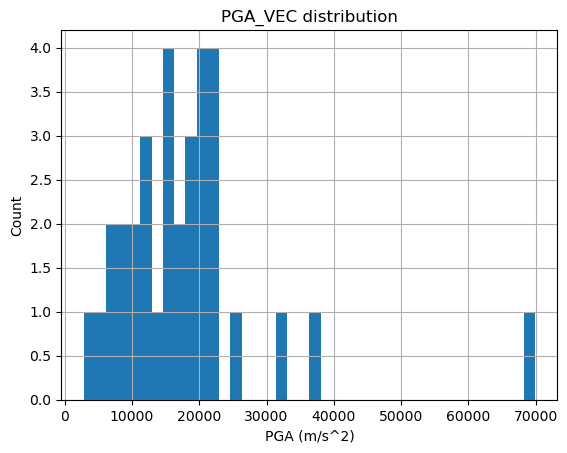

Not enough test data to plot.


In [10]:
import matplotlib.pyplot as plt

if len(pd.read_csv(FEATURES_CSV)):
    df_tmp = pd.read_csv(FEATURES_CSV)
    plt.figure()
    df_tmp['PGA_VEC'].hist(bins=40)
    plt.title('PGA_VEC distribution')
    plt.xlabel('PGA (m/s^2)')
    plt.ylabel('Count')
    plt.show()
else:
    print('No station-level features to plot.')

if len(test_out):
    plt.figure()
    plt.plot(test_out['event_time'], test_out[f'prob_next{HORIZON_HOURS}_h'])
    plt.title(f'Predicted P(another event within {HORIZON_HOURS}h)')
    plt.xlabel('Event time')
    plt.ylabel('Probability')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
else:
    print('Not enough test data to plot.')


In [11]:
event_meta.to_csv(EVENT_META_CSV, index=False)
test_out.to_csv(NOWCAST_CSV, index=False)
print('Saved event metadata →', EVENT_META_CSV)
print('Saved nowcast predictions →', NOWCAST_CSV)


Saved event metadata → /Users/soumyadip_iitk/Downloads/event_metadata.csv
Saved nowcast predictions → /Users/soumyadip_iitk/Downloads/nowcast_predictions.csv
